<a href="https://colab.research.google.com/github/Isac-AS/FSI_Practica_Redes_Neuronales_Flores/blob/fit_generator/FSI_Practica_Redes_Neuronales_Flores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación

Se monta el sistema de archivos de Google Drive.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se comprueba que se está usando una GPU

In [14]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

El dataset empleado es el siguiente: https://www.kaggle.com/alxmamaev/flowers-recognition.
Se muestra una imagen de ejemplo

flowers_recognition  flowers_recognition.zip  Sign-Language  Sign-Language.zip


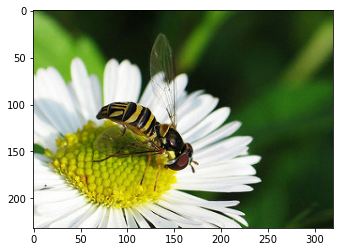

In [15]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/flowers_recognition/flowers/daisy/5547758_eea9edfd54_n.jpg', 'r')
imshow(np.asarray(pil_im))



# Carga del dataset

In [16]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 20

train_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/flowers_recognition/flowers'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/flowers_recognition/flowers'

train_datagen = ImageDataGenerator(
        rescale=1./255
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 4317 images belonging to 5 classes.
Found 4317 images belonging to 5 classes.


# Modelo

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
model = keras.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Entrenamiento

In [19]:
epochs = 150

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=6,
                   restore_best_weights=True)

h = model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [es]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/150
216/216 [==============================] - 709s 3s/step - loss: 1.5941 - accuracy: 0.2423 - val_loss: 1.5665 - val_accuracy: 0.3178
Epoch 2/150
216/216 [==============================] - 44s 203ms/step - loss: 1.5625 - accuracy: 0.3083 - val_loss: 1.5327 - val_accuracy: 0.3843
Epoch 3/150
216/216 [==============================] - 44s 203ms/step - loss: 1.5316 - accuracy: 0.3343 - val_loss: 1.4957 - val_accuracy: 0.4255
Epoch 4/150
216/216 [==============================] - 44s 203ms/step - loss: 1.5038 - accuracy: 0.3500 - val_loss: 1.4611 - val_accuracy: 0.4271
Epoch 5/150
216/216 [==============================] - 44s 203ms/step - loss: 1.4740 - accuracy: 0.3748 - val_loss: 1.4294 - val_accuracy: 0.4376
Epoch 6/150
216/216 [==============================] - 44s 204ms/step - loss: 1.4393 - accuracy: 0.3894 - val_loss: 1.4001 - val_accuracy: 0.4457
Epoch 7/150
216/216 [==============================] - 44s 204ms/step - loss: 1.4179 - accuracy: 0.4035 - val_loss: 1.3743 - v

# Guardado del modelo

In [20]:
model.save("modelo.h5")

# Visualización de resultados

In [21]:
import matplotlib.pyplot as plt

model = keras.models.load_model("modelo.h5")

plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.plot(model.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

TypeError: ignored

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_generator], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [ ]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/datasets/flowers_recognition/flowers/sunflower/6953297_8576bf4ea3.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))